# **Hyperparameters determination: Plots**
In this notebook, we will focus on hyperparameters determination and more specifically on plotting different graphs to get a visual understanding of how each parameter affects the overall missclassification error on testing sets. 

## **Importing the data**

In [2]:
import csv
import numpy as np

data_path = '../data/train.csv'

def load_csv_data(data_path, sub_sample=False):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    ids = x[:, 0].astype(np.int)
    input_data = x[:, 2:]

    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y == 'b')] = -1

    return yb, input_data, ids

y, x, ids = load_csv_data(data_path)

## **Cleaning the data**
One important step is to clean the data. One quick look to the data is enough to see that there are a lot of -999 values that shouldn't be here. One effective way to deal with it is to replace all these values by NaN, then calculating the median for each column and replacing the values by the median of their corresponding columns.

In [3]:
inds = np.where(x == -999)
x[inds] = np.nan

col_median = np.nanmedian(x, axis=0)

#Find indices that you need to replace
inds = np.where(np.isnan(x))

#Place column medians in the indices. Align the arrays using take
x[inds] = np.take(col_median, inds[1])

#Standardizing the data
xmin, xmax = np.min(x, axis=0), np.max(x, axis=0)
x = (x - xmin) / (xmax-xmin)

[ 1.124060e+02  4.652400e+01  7.375200e+01  3.846750e+01  2.107000e+00
  2.258850e+02 -2.440000e-01  2.491500e+00  1.231550e+01  1.206645e+02
  1.280000e+00 -3.560000e-01  4.540000e-01  3.180400e+01 -2.300000e-02
 -3.300000e-02  4.051600e+01 -4.500000e-02  8.600000e-02  3.480200e+01
 -2.400000e-02  1.797390e+02  1.000000e+00  6.556100e+01  0.000000e+00
 -3.300000e-02  4.790200e+01 -1.000000e-02 -2.000000e-03  4.051250e+01]
[ 1.20417434e+02  4.92398193e+01  8.11819816e+01  5.78959617e+01
  2.19310420e+00  2.68220619e+02 -4.11628932e-01  2.37309984e+00
  1.89173324e+01  1.58432217e+02  1.43760943e+00 -1.28304708e-01
  4.55244780e-01  3.87074191e+01 -1.09730480e-02 -8.17107200e-03
  4.66602072e+01 -1.95074680e-02  4.35429640e-02  4.17172345e+01
 -1.01191920e-02  2.09797178e+02  9.79176000e-01  7.71243656e+01
 -1.96589200e-03 -2.06285240e-02  5.07391493e+01 -1.05354440e-02
 -1.87879200e-03  7.30645914e+01]


## **Functions**
We will use the following functions to do a ridge regression. The goal here is to apply the `cross_validation_demo` function to plot the missclassification error on the test sets with different degrees and with different lambdas. By doing this, we will be able to get a understanding of what hyperparameters (degree and lambda) are best suited to solve our classification problem.

In [4]:
def build_poly(x, degree):

    """
    Builds polynomial augmented dataset
    :param x: (n,d) array
    :param degree: int
    :return: polynomial augmented array
    """
    r = x.copy()
    for deg in range (2,degree+1):
        r = np.c_[r, np.power(x, deg)]
        
    return np.c_[np.ones(r.shape[0]), r]

def build_k_indices(y, k_fold, seed):
    
    """
    Builds k index sets from input data
    :param y:
    :param k_fold:
    :param seed:
    :return: array of k_indices
    """
    num_row = y.shape[0]
    interval = int(num_row/k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k*interval: (k+1) * interval] for k in range (k_fold)]
    return np.array(k_indices)
            
def ridge_regression(y, tx, lambda_):
    
    """
    Ridge regression solver using normal equations
    :param y: (n,) array
    :param tx: (n,D) matrix
    :return: optimal weights vector
    """
    aI = 2 * tx.shape[0] * lambda_ * np.identity(tx.shape[1])
    a = tx.T.dot(tx) + aI
    b = tx.T.dot(y)
    return np.linalg.solve(a,b)

In [22]:
import pickle

def predict(tx, w):
    return tx.dot(w)

def cross_validation(y, x, k_indices, k, lambda_, degree):
    
    """
    Cross validation
    :param y: (n,) array
    :param x: (n,d) array
    :param k_indices: array of k_indices
    :param k: int
    :param lambda_: float
    :param degree: int
    :return: loss_tr, loss_te, w
    """
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te, y_tr = y[te_indice], y[tr_indice]
    x_te, x_tr = x[te_indice], x[tr_indice]
    
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)
    initial_w = np.ones(tx_tr.shape[1])
    
    w = ridge_regression(y_tr, tx_tr, lambda_)
    
    y_tr_pred = predict(tx_tr, w)
    y_te_pred = predict(tx_te, w)
    
    y_tr_pred[np.where(y_tr_pred <= 0)] = -1
    y_tr_pred[np.where(y_tr_pred > 0)] = 1
    
    y_te_pred[np.where(y_te_pred <= 0)] = -1
    y_te_pred[np.where(y_te_pred > 0)] = 1

    loss_tr = sum(y_tr_pred != y_tr)/len(y_tr)
    loss_te = sum(y_te_pred != y_te)/len(y_te)
    
    return loss_tr, loss_te, w

def cross_validation_demo():
    
    """Cross validation demo
    :return: best_degree, best_lambdas_per_degree, best_weights_per_degree, best_losses, best_losses_tr, losses_tr, losses_te
    """
   
    k_indices = build_k_indices(y, k_fold, seed)

    best_lambdas = []
    best_losses = []
    best_weights = []
    best_losses_tr = []
    losses_te_array = np.zeros((len(degrees),len(lambdas)))
    losses_tr_array = np.zeros((len(degrees),len(lambdas)))
    
    j = 0 #jth degree
    for index_deg, deg in enumerate(degrees):
        print(deg)
        i = 0 #ith lambda
        losses_te = []
        losses_tr = []
        ws = []
        for index_lambda, lambda_ in enumerate(lambdas):
            #print(f'Lambda {lambdas[i]}, degree {degrees[j]}')
            i += 1
            ws_tmp = []
            loss_te_tmp = []
            loss_tr_tmp = []

            for k in range(k_fold):
                #print(f'Fold {k}/{k_fold}')
                loss_tr, loss_te, w = cross_validation(y, x, k_indices, k, lambda_, deg)
                loss_te_tmp.append(loss_te)
                loss_tr_tmp.append(loss_tr)
                ws_tmp.append(w)
                
            mean_te = np.mean(loss_te_tmp, axis=0)
            mean_tr = np.mean(loss_tr_tmp, axis=0)
            
            losses_te.append(mean_te)
            losses_te_array[index_deg, index_lambda] = mean_te
            
            losses_tr.append(mean_tr)
            losses_tr_array[index_deg, index_lambda] = mean_tr
            
            ws.append(np.mean(ws_tmp, axis=0))
            
            def predict(tx, w):
                return tx.dot(w)

            #print(np.mean(loss_te_tmp, axis=0))

        j += 1
        ind_lambda_opt = np.argmin(loss_te)
        best_lambdas.append(lambdas[ind_lambda_opt])
        best_losses.append(losses_te[ind_lambda_opt])
        best_losses_tr.append(losses_tr[ind_lambda_opt])
        best_weights.append(ws[ind_lambda_opt])
        
        with open('../../vars_ridge.pkl', 'wb') as f:
            pickle.dump([best_lambdas,best_losses,best_losses_tr,best_weights], f)
        

    ind_best_degree = np.argmin(best_losses)

    return degrees[ind_best_degree], best_lambdas, best_weights, best_losses, best_losses_tr, losses_tr, losses_te, losses_te_array, losses_tr_array

## **Results**
Here are the results for different degrees. I used the `%store` in order to store the results and not losing them if Jupyter Notebooks kernel crashes.

In [23]:
"""Cross_validation_demo for the following parameters:"""
lambdas = np.logspace(-25, 4, 30)
degrees = np.arange(1,6,1)
seed = 12
k_fold = 10

best_degree, best_lambdas_per_degree, best_weights_per_degree, best_losses, best_losses_tr, losses_tr, losses_te, losses_te_array, losses_tr_array = cross_validation_demo()

best_degree_degree_1_5 = best_degree.copy()
best_lambdas_per_degree_1_5 = best_lambdas_per_degree.copy()
best_weights_per_degree_1_5 = best_weights_per_degree.copy()
best_losses_1_5 = best_losses.copy()
best_losses_tr_1_5 = best_losses_tr.copy()
losses_tr_1_5 = losses_tr.copy()
losses_te_1_5 = losses_te.copy()
losses_te_array_1_5 = losses_te_array.copy()
losses_tr_array_1_5 = losses_tr_array.copy()

%store best_degree_degree_1_5
%store best_lambdas_per_degree_1_5
%store best_weights_per_degree_1_5
%store best_losses_1_5
%store best_losses_tr_1_5
%store losses_tr_1_5
%store losses_te_1_5
%store losses_te_array_1_5
%store losses_tr_array_1_5


1
2
3
4
5
Stored 'best_degree_degree_1_5' (int64)
Stored 'best_lambdas_per_degree_1_5' (list)
Stored 'best_weights_per_degree_1_5' (list)
Stored 'best_losses_1_5' (list)
Stored 'best_losses_tr_1_5' (list)
Stored 'losses_tr_1_5' (list)
Stored 'losses_te_1_5' (list)
Stored 'losses_te_array_1_5' (ndarray)
Stored 'losses_tr_array_1_5' (ndarray)


In [9]:
"""Cross_validation_demo for the following parameters:"""
lambdas = np.logspace(-25, 4, 30)
degrees = np.arange(6,11,1)
seed = 12
k_fold = 10

best_degree, best_lambdas_per_degree, best_weights_per_degree, best_losses, best_losses_tr, losses_tr, losses_te, losses_te_array, losses_tr_array = cross_validation_demo()

best_degree_degree_6_10 = best_degree.copy()
best_lambdas_per_degree_6_10 = best_lambdas_per_degree.copy()
best_weights_per_degree_6_10 = best_weights_per_degree.copy()
best_losses_6_10 = best_losses.copy()
best_losses_tr_6_10 = best_losses_tr.copy()
losses_tr_6_10 = losses_tr.copy()
losses_te_6_10 = losses_te.copy()

%store best_degree_degree_6_10
%store best_lambdas_per_degree_6_10
%store best_weights_per_degree_6_10
%store best_losses_6_10
%store best_losses_tr_6_10
%store losses_tr_6_10
%store losses_te_6_10
%store losses_te_array_6_10
%store losses_tr_array_6_10

Stored 'best_degree_degree_6_10' (int64)
Stored 'best_lambdas_per_degree_6_10' (list)
Stored 'best_weights_per_degree_6_10' (list)
Stored 'best_losses_6_10' (list)
Stored 'best_losses_tr_6_10' (list)
Stored 'losses_tr_6_10' (list)
Stored 'losses_te_6_10' (list)


In [11]:
"""Cross_validation_demo for the following parameters:"""
lambdas = np.logspace(-25, 4, 30)
degrees = np.arange(11,16,1)
seed = 12
k_fold = 10

best_degree, best_lambdas_per_degree, best_weights_per_degree, best_losses, best_losses_tr, losses_tr, losses_te, losses_te_array, losses_tr_array = cross_validation_demo()

best_degree_degree_11_15 = best_degree.copy()
best_lambdas_per_degree_11_15 = best_lambdas_per_degree.copy()
best_weights_per_degree_11_15 = best_weights_per_degree.copy()
best_losses_11_15 = best_losses.copy()
best_losses_tr_11_15 = best_losses_tr.copy()
losses_tr_11_15 = losses_tr.copy()
losses_te_11_15 = losses_te.copy()

%store best_degree_degree_11_15
%store best_lambdas_per_degree_11_15
%store best_weights_per_degree_11_15
%store best_losses_11_15
%store best_losses_tr_11_15
%store losses_tr_11_15
%store losses_te_11_15
%store losses_te_array_11_15
%store losses_tr_array_11_15

Stored 'best_degree_degree_11_15' (int64)
Stored 'best_lambdas_per_degree_11_15' (list)
Stored 'best_weights_per_degree_11_15' (list)
Stored 'best_losses_11_15' (list)
Stored 'best_losses_tr_11_15' (list)
Stored 'losses_tr_11_15' (list)
Stored 'losses_te_11_15' (list)


## **Plots**
We will now plot different graphs to get an understanding of how the missclassification evolves when changing the hyperparameters (degree and $\lambda$)

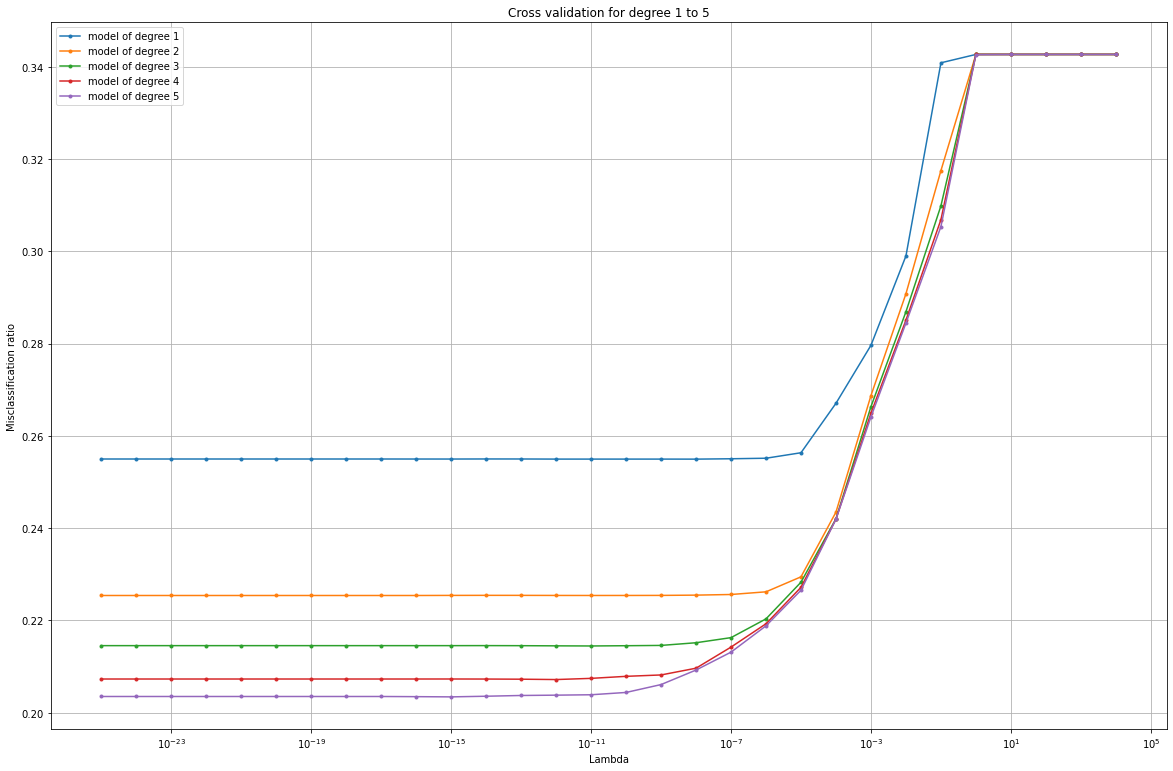

In [37]:
import matplotlib.pyplot as plt
import math

lambdas = np.logspace(-25, 4, 30)

fig, ax = plt.subplots(1,1,sharex = True, sharey = True, figsize = (20,13))

for degree in range(1,6):
    plt.semilogx(lambdas, losses_te_array_1_5[degree - 1] , marker=".", label = 'model of degree {}'.format(degree))
    plt.xlabel("Lambda")
    plt.ylabel("Misclassification ratio")
    plt.title("Cross validation for degree 1 to 5".format(degree))
    plt.legend(loc=2)
    plt.grid(True)

plt.savefig("cross_validation_degree_1_5")